In [179]:
#import packages and life tables
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
import random
import math
from typing import Tuple
import statsmodels.api as sm
#life_table=pd.DataFrame()
#male_lifetable=pd.read_csv("/Users/haoquan/Desktop/UW/Research/simulation va and rila/Life_table_male.csv")
#female_lifetable=pd.read_csv("/Users/haoquan/Desktop/UW/Research/simulation va and rila/Life_table_female.csv")
import warnings
warnings.filterwarnings("ignore")
sns.set()
import sys
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import MinMaxScaler

life_table=pd.DataFrame()
male_smoker_lifetable=pd.read_csv("/Users/haoquan/Desktop/UW/Research/simulation va and rila/male smoker.csv", encoding='latin1')
female_smoker_lifetable=pd.read_csv("/Users/haoquan/Desktop/UW/Research/simulation va and rila/female smoker.csv", encoding='latin1')
male_nonsmoker_lifetable=pd.read_csv("/Users/haoquan/Desktop/UW/Research/simulation va and rila/male nonsmoker.csv", encoding='latin1')
female_nonsmoker_lifetable=pd.read_csv("/Users/haoquan/Desktop/UW/Research/simulation va and rila/female nonsmoker.csv", encoding='latin1')
class QF_VA:
    """Analytic valuation of the option-like leg **C** for a Variable
    Annuity with GMDB/GMAB guarantees under Black–Scholes dynamics that
    include a continuous management fee *φ* (treated as a dividend
    yield).

    The class delivers a *deterministic* price; no Monte‑Carlo is used.
    """

    # ------------------------------------------------------------------
    #  Construction
    # ------------------------------------------------------------------
    def __init__(self,
                 male_ratio: float = 0.0,
                 smoker_ratio: float = 0.0,
                 contract_duration: int = 25,
                 premium_paid: float = 10_000.0,
                 fee: float = 0.0,
                 age: int = 40,
                 rf: float = 0.04,
                 GMAB_rate: float = 0.06,
                 sigma: float = 0.15):

        # Demographic mixture
        if not (0.0 <= male_ratio <= 1.0):
            raise ValueError("male_ratio must be in [0,1]")
        if not (0.0 <= smoker_ratio <= 1.0):
            raise ValueError("smoker_ratio must be in [0,1]")
        self.male_ratio = male_ratio
        self.smoker_ratio = smoker_ratio

        # Contract & economic inputs
        self.M     = contract_duration
        self.P     = premium_paid     # also initial account value A0
        self.varphi = fee             # management fee (dividend yield)
        self.age   = age
        self.rf    = rf
        self.r_A   = GMAB_rate        # roll‑up of strike at maturity
        self.sigma = sigma

    # ------------------------------------------------------------------
    #  Demographic helpers
    # ------------------------------------------------------------------
    @staticmethod
    def _life_table(gender: str, smoker: bool):
        if gender == "Male" and smoker:
            return male_smoker_lifetable
        if gender == "Female" and smoker:
            return female_smoker_lifetable
        if gender == "Male" and not smoker:
            return male_nonsmoker_lifetable
        if gender == "Female" and not smoker:
            return female_nonsmoker_lifetable
        raise ValueError("Invalid gender/smoker combination")

    def _tpx(self, t: int, lt) -> float:
        """{}_tp_x from current age *x* to *x+t*."""
        idx = lt.index[lt["age"] == self.age][0]
        qx_slice = lt["Death probabilities"].iloc[idx : idx + t]
        return float(np.prod(1.0 - qx_slice.values))

    def _iqxt(self, t: int, lt) -> float:
        """Return {}_1q_{x+t}."""
        idx = lt.index[lt["age"] == self.age][0]
        return float(lt["Death probabilities"].iloc[idx + t])

    # ------------------------------------------------------------------
    #  Black‑Scholes with dividend yield (management fee) ---------------
    # ------------------------------------------------------------------
    def _norm_cdf(self, x: float) -> float:
        return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

    def _bs_call(self, S0: float, K: float, T: int) -> float:
        """Fee‑adjusted Black‑Scholes price of a European call."""
        if T == 0:
            return max(S0 - K, 0.0)  # should never occur but safe‑guard
        sigma = self.sigma
        varphi = self.varphi
        rf = self.rf
        sqrtT = math.sqrt(T)
        d1 = (math.log(S0 / K) + (rf - varphi + 0.5 * sigma**2) * T) / (sigma * sqrtT)
        d2 = d1 - sigma * sqrtT
        return (
            S0 * math.exp(-varphi * T) * self._norm_cdf(d1) -
            K  * math.exp(-rf * T)    * self._norm_cdf(d2)
        )

    # ------------------------------------------------------------------
    #  Core pricing routine --------------------------------------------
    # ------------------------------------------------------------------
    def price_C(self) -> float:
        """Return the full present value V(φ) = deterministic leg + C."""
        A0 = self.P   # current account value equals premium
        P  = self.P
        rA = self.r_A
        M  = self.M
        rf = self.rf

        total_value = 0.0

        # Iterate over demographic groups and weight
        for gender, g_prob in [("Male",  self.male_ratio),
                               ("Female", 1 - self.male_ratio)]:
            for smoker, s_prob in [(True,  self.smoker_ratio),
                                   (False, 1 - self.smoker_ratio)]:
                weight = g_prob * s_prob
                if weight == 0.0:
                    continue  # skip impossible group
                lt = self._life_table(gender, smoker)

                # Pre-compute survival / mortality vectors
                surv = np.fromiter((self._tpx(t=i, lt=lt)   for i in range(1, M + 1)), dtype=float)
                mort = np.fromiter((self._iqxt(t=i, lt=lt) for i in range(1, M)),     dtype=float)

                # ---------------- Deterministic fixed‑payment leg ------
                fixed_leg  = surv[-1] * math.exp(-rf * M) * P * math.exp(rA * M)
                years = np.arange(1, M)
                fixed_leg += np.sum(P * surv[:-1] * mort * np.exp(-rf * years))

                # ---------------- Option‑like leg C (Black‑Scholes) ----
                # maturity call
                C_value = surv[-1] * self._bs_call(A0, P * math.exp(rA * M), M)
                # death‑time calls
                for t in range(1, M):
                    C_value += surv[t-1] * mort[t-1] * self._bs_call(A0, P, t)

                group_value = fixed_leg + C_value
                total_value += weight * group_value

        return total_value

    # ------------------------------------------------------------------
    #  Convenience
    # ------------------------------------------------------------------
    def __call__(self):
        return self.price_C()
class QF_VA_simulation:
    def __init__(self, iterations=5000, 
                 male_ratio=0, smoker_ratio=0,
                 contract_duration=25, 
                 premium_paid=10000, S0=21, fee=0, DB_type=0, #"Return of Premium": 0, "Rachet": 2, "Rollup": 1,
                 AB_type=0, #"Return of Premium": 0, "Rachet": 2, "Rollup": 1, "DNE": 3
                 WB_type=0,
                 age=40, rf=0.015,GMDB_rate=0.04,GMAB_rate=0.06,GMWB_rate=0.04,maxW=0.07,
                 mu=0.04, sigma=0.15, dt=1):
        
        # Number of simulations
        self.iterations = iterations
        
        # Ratio of males and smokers
        self.male_ratio = male_ratio
        self.smoker_ratio = smoker_ratio
        
        # Contract parameters
        self.contract_duration = contract_duration
        self.premium_paid = premium_paid
        
        # Underlying asset price
        self.S0 = S0
        self.fee = fee
        self.GMDB_rate=GMDB_rate
        self.GMAB_rate=GMAB_rate
        self.GMWB_rate=GMWB_rate
        self.maxW=maxW
        
        # Age and risk-free rate
        self.age = age
        self.rf = rf
        
        # Brownian motion parameters
        self.mu = mu
        self.sigma = sigma
        self.dt = dt

        # Riders' Type
        self.DB_type = DB_type
        self.AB_type = AB_type
        self.WB_type = WB_type

    def generate_random_gender(self):
        random_number = random.random()
        return "Male" if random_number < self.male_ratio else "Female"
    
    def generate_random_smoker(self):
        random_number = random.random()
        return True if random_number < self.smoker_ratio else False
    
    def Brownian_motion(self, N):
        dt = self.dt
        mu = self.mu
        sigma = self.sigma
        Z = np.random.standard_normal(N)
        log_returns = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
        
        return log_returns.tolist()

    def life_table(self):
        gender = self.generate_random_gender()
        smoker = self.generate_random_smoker()
        life_table = None
        
        # Select the correct life table based on gender and smoking status
        if (gender == "Male") and smoker:
            life_table = male_smoker_lifetable
        elif (gender == "Female") and smoker:
            life_table = female_smoker_lifetable
        elif (gender == "Male") and (not smoker):
            life_table = male_nonsmoker_lifetable
        elif (gender == "Female") and (not smoker):
            life_table = female_nonsmoker_lifetable
        else:
            raise ValueError("Error in assigning life table.")

        return life_table

    def tpx(self,t):
        life_table=self.life_table()
        x= self.age
        index=life_table.loc[life_table["age"]==x].index[0]
        survive=1-life_table["Death probabilities"][index:(index+t)]
        p=1
        for i in survive:
           p*=i
        return p

    def iqxt(self,t):
        life_table=self.life_table()
        x= self.age
        index=life_table.loc[life_table["age"]==x].index[0]
        return life_table["Death probabilities"][index+t]

    def ABRU(self):
        # Short aliases
        iters      = self.iterations
        n          = self.contract_duration
        rf         = self.rf
        premium    = self.premium_paid
        fee        = self.fee
        DB_type    = self.DB_type
        GMDB_rate  = self.GMDB_rate
        GMWB_rate  = self.GMWB_rate
        GMAB_rate  = self.GMAB_rate
    
        tpx, iqxt = self.tpx, self.iqxt
    
        # Pre‑compute arrays
        years = np.arange(1, n+1)
        surv  = np.fromiter((tpx(t=i)   for i in years), dtype=float)
        mort  = np.fromiter((iqxt(t=i) for i in years), dtype=float)
        disc  = np.exp(-rf * years)
    
        Final = np.empty(iters)
    
        for k in range(iters):
            returns = self.Brownian_motion(N=n)
    
            # allocate state arrays
            A   = np.empty(n+1)
            G_D = np.empty(n+1)
            G_A = np.empty(n+1)
            E   = np.zeros(n+1)
    
            # initialize
            A[0]   = premium
            G_D[0] = premium
            G_A[0] = premium
            A_t    = premium
            G_Dt   = premium
            G_At   = premium
    
            for j in range(n):
                # grow account
                A_t *= np.exp(returns[j] - fee)
    
                # no withdrawals
                E_t     = 0.0
                E[j+1]  = E_t * disc[j]
    
                # death‑benefit guarantee update
                if DB_type == 0:
                    cumE    = E[1:j+1].sum()
                    G_D_pre = premium - cumE
                elif DB_type == 1:
                    G_D_pre = G_Dt * np.exp(GMDB_rate)
                else:
                    G_D_pre = max(G_Dt, A_t)
                G_Dt      = max(G_D_pre - E_t, 0.0)
                G_D[j+1]  = G_Dt
    
                # accumulation benefit roll‑up
                G_A_pre   = G_At * np.exp(GMAB_rate)
                G_At      = max(G_A_pre - E_t, 0.0)
                G_A[j+1]  = G_At
    
                A[j+1]    = A_t
                A_tp      = max(A_t - E_t, 0.0)
            # death‑benefit leg
            cumE_arr = np.cumsum(E[1:])
            leg      = surv * mort * (
                           np.maximum(A[1:], G_D[1:]) * disc
                           + cumE_arr
                       )
            payoff   = leg.sum()
            # terminal accumulation benefit
            terminal = tpx(t=n) * (
                           max(A[-1], G_A[-1]) * np.exp(-rf * n)
                           + E.sum()
                       )
            Final[k] = payoff + terminal
    
        return Final.tolist()
class QF_VA_simulation_crn:
    def __init__(self, iterations=5000, 
                 male_ratio=0, smoker_ratio=0,
                 contract_duration=25, 
                 premium_paid=10000, S0=21, fee=0, DB_type=0, #"Return of Premium": 0, "Rachet": 2, "Rollup": 1,
                 AB_type=0, #"Return of Premium": 0, "Rachet": 2, "Rollup": 1, "DNE": 3
                 WB_type=0,
                 age=40, rf=0.015,GMDB_rate=0.04,GMAB_rate=0.06,GMWB_rate=0.04,maxW=0.07,
                 mu=0.04, sigma=0.15, dt=1, seed = 42):
        
        # Number of simulations
        self.iterations = iterations
        
        # Ratio of males and smokers
        self.male_ratio = male_ratio
        self.smoker_ratio = smoker_ratio
        
        # Contract parameters
        self.contract_duration = contract_duration
        self.premium_paid = premium_paid
        
        # Underlying asset price
        self.S0 = S0
        self.fee = fee
        self.GMDB_rate=GMDB_rate
        self.GMAB_rate=GMAB_rate
        self.GMWB_rate=GMWB_rate
        self.maxW=maxW
        
        # Age and risk-free rate
        self.age = age
        self.rf = rf
        
        # Brownian motion parameters
        self.mu = mu
        self.sigma = sigma
        self.dt = dt

        # Riders' Type
        self.DB_type = DB_type
        self.AB_type = AB_type
        self.WB_type = WB_type

        #set_seed
        self.seed = seed

    def generate_random_gender(self):
        random_number = random.random()
        return "Male" if random_number < self.male_ratio else "Female"
    
    def generate_random_smoker(self):
        random_number = random.random()
        return True if random_number < self.smoker_ratio else False
    
    def Brownian_motion(self, N, seed=42):
        if seed is not None:
            np.random.seed(seed)  # Set seed if provided
        dt = self.dt
        mu = self.mu
        sigma = self.sigma
        Z = np.random.standard_normal(N)
        log_returns = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
        return log_returns.tolist()


    def life_table(self):
        gender = self.generate_random_gender()
        smoker = self.generate_random_smoker()
        life_table = None
        
        # Select the correct life table based on gender and smoking status
        if (gender == "Male") and smoker:
            life_table = male_smoker_lifetable
        elif (gender == "Female") and smoker:
            life_table = female_smoker_lifetable
        elif (gender == "Male") and (not smoker):
            life_table = male_nonsmoker_lifetable
        elif (gender == "Female") and (not smoker):
            life_table = female_nonsmoker_lifetable
        else:
            raise ValueError("Error in assigning life table.")

        return life_table

    def tpx(self,t):
        life_table=self.life_table()
        x= self.age
        index=life_table.loc[life_table["age"]==x].index[0]
        survive=1-life_table["Death probabilities"][index:(index+t)]
        p=1
        for i in survive:
           p*=i
        return p

    def iqxt(self,t):
        life_table=self.life_table()
        x= self.age
        index=life_table.loc[life_table["age"]==x].index[0]
        return life_table["Death probabilities"][index+t]

    def ABRU(self):
        # Short aliases
        iters      = self.iterations
        n          = self.contract_duration
        rf         = self.rf
        premium    = self.premium_paid
        fee        = self.fee
        DB_type    = self.DB_type
        GMDB_rate  = self.GMDB_rate
        GMWB_rate  = self.GMWB_rate
        GMAB_rate  = self.GMAB_rate
    
        tpx, iqxt = self.tpx, self.iqxt
    
        # Pre‑compute arrays
        years = np.arange(1, n+1)
        surv  = np.fromiter((tpx(t=i)   for i in years), dtype=float)
        mort  = np.fromiter((iqxt(t=i) for i in years), dtype=float)
        disc  = np.exp(-rf * years)
    
        Final = np.empty(iters)
        paths = np.vstack([self.Brownian_motion(n, seed=self.seed + i) for i in range(iters)])
        #print(paths)
        for k in range(iters):
            returns = self.Brownian_motion(N=n)
    
            # allocate state arrays
            A   = np.empty(n+1)
            G_D = np.empty(n+1)
            G_A = np.empty(n+1)
            E   = np.zeros(n+1)
    
            # initialize
            A[0]   = premium
            G_D[0] = premium
            G_A[0] = premium
            A_t    = premium
            G_Dt   = premium
            G_At   = premium
    
            for j in range(n):
                # grow account
                #print(paths[k,j])
                A_t *= np.exp(paths[k,j] - fee)
    
                # no withdrawals
                E_t     = 0.0
                E[j+1]  = E_t * disc[j]
    
                # death‑benefit guarantee update
                if DB_type == 0:
                    cumE    = E[1:j+1].sum()
                    G_D_pre = premium - cumE
                elif DB_type == 1:
                    G_D_pre = G_Dt * np.exp(GMDB_rate)
                else:
                    G_D_pre = max(G_Dt, A_t)
                G_Dt      = max(G_D_pre - E_t, 0.0)
                G_D[j+1]  = G_Dt
    
                # accumulation benefit roll‑up
                G_A_pre   = G_At * np.exp(GMAB_rate)
                G_At      = max(G_A_pre - E_t, 0.0)
                G_A[j+1]  = G_At
    
                A[j+1]    = A_t
                A_tp      = max(A_t - E_t, 0.0)
            # death‑benefit leg
            cumE_arr = np.cumsum(E[1:])
            leg      = surv * mort * (
                           np.maximum(A[1:], G_D[1:]) * disc
                           + cumE_arr
                       )
            payoff   = leg.sum()
            # terminal accumulation benefit
            terminal = tpx(t=n) * (
                           max(A[-1], G_A[-1]) * np.exp(-rf * n)
                           + E.sum()
                       )
            Final[k] = payoff + terminal
        return Final.tolist()

In [141]:
bs_payoffs=[]
for i in np.arange (0,0.055,0.005):
    male_ratio = 1
    age = 40
    smoker_ratio = 0
    premium_paid = 10000.0
    maxW = 0
    GMAB_rate = 0.03
    contract_duration = 25
    Simulator = QF_VA(male_ratio= male_ratio, smoker_ratio = 0.0, 
                      contract_duration= contract_duration,premium_paid= premium_paid,
                      fee= i,age = age,rf = 0.04,
                      GMAB_rate= GMAB_rate,sigma= 0.15)
    final_value = Simulator.__call__()
    bs_payoffs.append(final_value)
    print(f"{i} is done")
abdb=bs_payoffs
abdb

0.0 is done
0.005 is done
0.01 is done
0.015 is done
0.02 is done
0.025 is done
0.03 is done
0.035 is done
0.04 is done
0.045 is done
0.05 is done


[11473.028740726611,
 10625.904815740036,
 9930.979928729386,
 9368.223898377222,
 8918.729409344496,
 8564.854537647512,
 8290.39694817749,
 8080.758333499321,
 7923.065443155622,
 7806.225790008018,
 7720.909328617791]

In [101]:
payoff=0
payoffs=[]
for i in np.arange (0,0.055,0.005):
    male_ratio = 1
    age = 40
    smoker_ratio = 0
    premium_paid = 10000
    maxW = 0
    GMAB_rate = 0.03
    contract_duration = 25
    GMDB_Type=1
    GMWB_Type=0
    Simulator = QF_VA_simulation(iterations = int(10000), 
                  male_ratio = male_ratio, smoker_ratio = smoker_ratio,
                  contract_duration = int(contract_duration), 
                  premium_paid = premium_paid, S0 = 21, fee = i, 
                  age = int(age), rf = 0.04, GMAB_rate = GMAB_rate, maxW = maxW/100,mu= 0.04, 
                  sigma = 0.15, dt = 1)
    final_value = Simulator.ABRU() 
    payoff=np.mean(final_value)
    payoffs.append(payoff)
    print(f"{i} is done")
abru=payoffs
abru

0.0 is done
0.005 is done
0.01 is done
0.015 is done
0.02 is done
0.025 is done
0.03 is done
0.035 is done
0.04 is done
0.045 is done
0.05 is done


[11592.473965145067,
 10776.359690056885,
 10021.621252791176,
 9394.311709948184,
 8987.780465963533,
 8661.578442211481,
 8390.585479766323,
 8168.6167203398045,
 7975.836080523007,
 7843.376899933058,
 7774.754012443835]

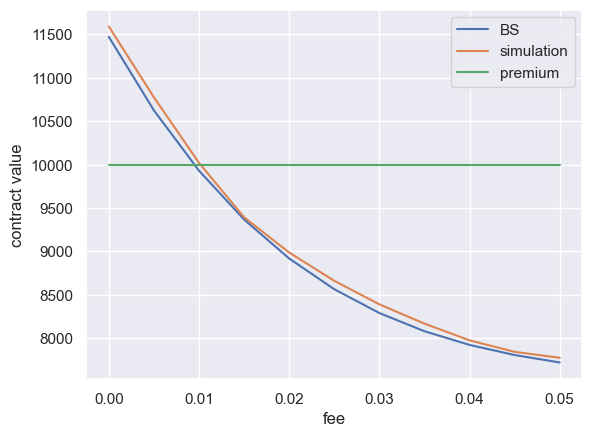

In [104]:
p=[10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000]
import matplotlib.pyplot as plt
x = np.arange (0,0.055,0.005)
plt.plot (x, abdb, label = "BS")
plt.plot (x, abru, label = "simulation")
plt.plot (x, p, label = "premium")
plt.xlabel("fee")
plt.ylabel("contract value")
plt.legend()
plt.show()#removepremium

In [161]:
def iid_simu(num_sim=100,num_ex=500,alpha=0.05,ab_ru=0.03,rf=0.04,sigma=0.15,contract_duration=20,age=40):
    #simulation
    dic={}
    for j in np.arange(num_ex):   
        payoff=0
        payoffs=[]
        for i in np.arange (0,0.055,0.005):
            male_ratio = 1
            age = age
            smoker_ratio = 0
            premium_paid = 10000
            maxW = 0
            GMDB_rate = 10000
            contract_duration = contract_duration
            Simulator = QF_VA_simulation(iterations = num_sim, 
                          male_ratio = male_ratio, smoker_ratio = smoker_ratio,
                          contract_duration = int(contract_duration), 
                          premium_paid = premium_paid, S0 = 21, fee = i, 
                          age = int(age), rf = rf, GMAB_rate = ab_ru, maxW = maxW/100,mu= rf, 
                          sigma = sigma, dt = 1)
            final_value = Simulator.ABRU() 
            payoff=np.mean(final_value)
            payoffs.append(payoff)
        plt.plot(payoffs, color='blue', alpha=0.04)
        dic[j]=payoffs
    #bs close form
    bs_payoffs=[]
    for i in np.arange (0,0.055,0.005):
        male_ratio = 1
        age = 40
        smoker_ratio = 0
        premium_paid = 10000.0
        maxW = 0
        contract_duration = contract_duration
        Simulator = QF_VA(male_ratio= male_ratio, smoker_ratio = 0.0, 
                          contract_duration= contract_duration,premium_paid= premium_paid,
                          fee= i,age = age,rf = 0.04,
                          GMAB_rate= ab_ru,sigma= 0.15)
        final_value = Simulator.__call__()
        bs_payoffs.append(final_value)
        
    # Plot the true value in red
    plt.plot(bs_payoffs, color='red', linewidth=2, label='True Value')
    
    #plot quantile
    data = np.array(list(dic.values()))
    # Compute alpha-quantile along axis 0 for each column (i.e., each i-th element)
    quantiles_lower = np.quantile(data, alpha, axis=0)
    quantiles_upper = np.quantile(data, 1-alpha, axis=0)
    plt.plot(range(len(quantiles_lower)), quantiles_lower, color='green',label='Lower CI')
    plt.plot(range(len(quantiles_upper)), quantiles_upper, color='green',label='Upper CI')
    # Optional: add legend and show
    plt.legend()
    plt.title(f"Simulations vs True Value when num_sim is {num_sim}")
    plt.xlabel("discounted payoffs")
    plt.ylabel("fee")
    plt.show()
    data = np.array(list(dic.values()))

    return dic

In [184]:
def iid_simu_crn(num_sim=100,num_ex=500,alpha=0.05,ab_ru=0.03,rf=0.04,sigma=0.15,contract_duration=20,age=40,seed=42):
    #simulation
    dic={}
    for j in np.arange(num_ex):   
        payoff=0
        payoffs=[]
        for i in np.arange (0,0.055,0.005):
            male_ratio = 1
            age = age
            smoker_ratio = 0
            premium_paid = 10000
            maxW = 0
            GMDB_rate = 10000
            contract_duration = contract_duration
            Simulator = QF_VA_simulation_crn(iterations = num_sim, 
                          male_ratio = male_ratio, smoker_ratio = smoker_ratio,
                          contract_duration = int(contract_duration), 
                          premium_paid = premium_paid, S0 = 21, fee = i, 
                          age = int(age), rf = rf, GMAB_rate = ab_ru, maxW = maxW/100,mu= rf, 
                          sigma = sigma, dt = 1,seed=seed+j)
            final_value = Simulator.ABRU() 
            payoff=np.mean(final_value)
            payoffs.append(payoff)
        plt.plot(payoffs, color='blue', alpha=0.04)
        dic[j]=payoffs
    #bs close form
    bs_payoffs=[]
    for i in np.arange (0,0.055,0.005):
        male_ratio = 1
        age = 40
        smoker_ratio = 0
        premium_paid = 10000.0
        maxW = 0
        contract_duration = contract_duration
        Simulator = QF_VA(male_ratio= male_ratio, smoker_ratio = 0.0, 
                          contract_duration= contract_duration,premium_paid= premium_paid,
                          fee= i,age = age,rf = 0.04,
                          GMAB_rate= ab_ru,sigma= 0.15)
        final_value = Simulator.__call__()
        bs_payoffs.append(final_value)
        
    # Plot the true value in red
    plt.plot(bs_payoffs, color='red', linewidth=2, label='True Value')
    
    #plot quantile
    data = np.array(list(dic.values()))
    # Compute alpha-quantile along axis 0 for each column (i.e., each i-th element)
    quantiles_lower = np.quantile(data, alpha, axis=0)
    quantiles_upper = np.quantile(data, 1-alpha, axis=0)
    plt.plot(range(len(quantiles_lower)), quantiles_lower, color='green',label='Lower CI')
    plt.plot(range(len(quantiles_upper)), quantiles_upper, color='green',label='Upper CI')
    # Optional: add legend and show
    plt.legend()
    plt.title(f"Simulations vs True Value when num_sim is {num_sim}")
    plt.xlabel("discounted payoffs")
    plt.ylabel("fee")
    plt.show()
    data = np.array(list(dic.values()))

    return dic

In [121]:
from math import sqrt

# ----------------------------------------------------------------------
# 1. Fair-fee detector  (same logic as before)
# ----------------------------------------------------------------------
def fair_fee(dic: dic_one, strategy: str = "first") -> pd.Series:
    if strategy not in {"first", "average", "dne"}:
        raise ValueError("strategy must be 'first', 'average', or 'dne'")
    df=pd.DataFrame(dic)-10000
    new_column = np.arange(0, 0.055, 0.005)  # Shape (11,)
    # Add it as the first column in the DataFrame
    df.insert(0, 'Fee', new_column)

    fees = df["Fee"].to_numpy()
    roots_per_sim = {}

    for col in df.columns.drop("Fee"):
        vals = df[col].to_numpy()
        sgn  = np.sign(vals)
        roots = []

        # exact zeros
        if (sgn == 0).any():
            roots.extend(fees[sgn == 0])

        # sign changes
        idx = np.where(sgn[:-1] * sgn[1:] < 0)[0]
        for i in idx:
            f0, f1   = vals[i], vals[i + 1]
            fee0, fee1 = fees[i], fees[i + 1]
            root = fee0 - f0 * (fee1 - fee0) / (f1 - f0)
            roots.append(root)

        if len(roots) == 0:
            roots_per_sim[col] = np.nan            # DNE
        elif len(roots) == 1:
            roots_per_sim[col] = roots[0]
        else:
            if strategy == "first":
                roots_per_sim[col] = min(roots)
            elif strategy == "average":
                roots_per_sim[col] = np.mean(roots)
            else:                                  # "dne"
                roots_per_sim[col] = np.nan

    return pd.Series(roots_per_sim, name="fair_fee")

In [123]:
def plot_fairfee_estimates(fair_series: np.ndarray, true_fee: float):
    """
    Plot histogram and error chart of fair fee estimates against the true fee.
    Includes standard error calculations.

    Parameters
    ----------
    fair_series : pd.Series or array-like
        Series of estimated fair fees.
    true_fee : float
        The known true fee to compare against.
    """
    # Convert to numpy array and drop NaNs
    fees = np.asarray(fair_series.dropna()) if hasattr(fair_series, "dropna") else np.asarray(fair_series)
    N = len(fees)

    if N == 0:
        print("No valid fair-fee estimates to plot.")
        return

    errors = fees - true_fee

    # 1. Histogram of estimated fair fees
    plt.figure(figsize=(8, 5))
    plt.hist(fees, bins="auto", edgecolor='black')
    plt.axvline(true_fee, linestyle="--", color='red', linewidth=2, label=f"True fee = {true_fee:.4f}")
    plt.title("Histogram of Estimated Fair Fees")
    plt.xlabel("Estimated Fair Fee")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. Error scatter plot
    plt.figure(figsize=(8, 5))
    plt.plot(errors, marker='o', linestyle='none', alpha=0.6)
    plt.axhline(0, linestyle="--", color='gray', linewidth=1)
    plt.title("Estimation Error per Simulation")
    plt.xlabel("Simulation Index")
    plt.ylabel("Error (Estimate − True Fee)")
    plt.tight_layout()
    plt.show()

    # 3. Histogram of errors
    plt.figure(figsize=(8, 5))
    plt.hist(errors, bins="auto", edgecolor='black')
    plt.axvline(0, linestyle="--", color='red', linewidth=2)
    plt.title("Histogram of Estimation Errors")
    plt.xlabel("Error (Estimate − True Fee)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # 4. Compute and print standard errors
    sigma_fee = np.std(fees, ddof=1)
    sigma_error = np.std(errors, ddof=1)
    se_fee = sigma_fee / sqrt(N)
    se_error = sigma_error / sqrt(N)

    print(f"Number of estimates (N): {N}")
    print(f"Standard error of fee estimates  : {se_fee:.6g}")
    print(f"Standard error of errors         : {se_error:.6g}")

In [118]:
# calculate the true fee
fees = np.linspace(0, 0.05, 11)
values = np.array([
    11473.028740726611,
    10625.904815740036,
    9930.979928729386,
    9368.223898377222,
    8918.729409344496,
    8564.854537647512,
    8290.39694817749,
    8080.758333499321,
    7923.065443155622,
    7806.225790008018,
    7720.909328617791
])-10000

# Linear interpolation to find fee where value crosses zero
for i in range(len(values) - 1):
    v0, v1 = values[i], values[i + 1]
    if v0 * v1 < 0:  # Sign change indicates zero crossing
        f0, f1 = fees[i], fees[i + 1]
        root_fee = f0 - v0 * (f1 - f0) / (v1 - v0)
        print(f"Fair fee (value = 0) is approximately: {root_fee:.6f}")
        break
else:
    print("No zero crossing found; true price is maximum at fee = 0:")

Fair fee (value = 0) is approximately: 0.009503


## simulation without crn using num_sim=100
### CI of discounted payoffs

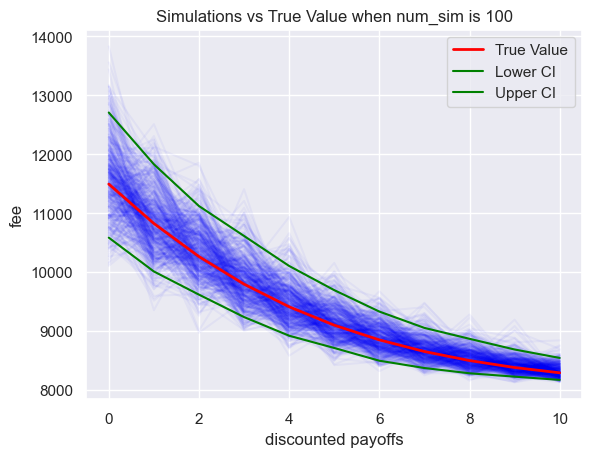

In [135]:
dic_one=iid_simu(num_sim=100)

### histgram of simulation fees and "true" fee.

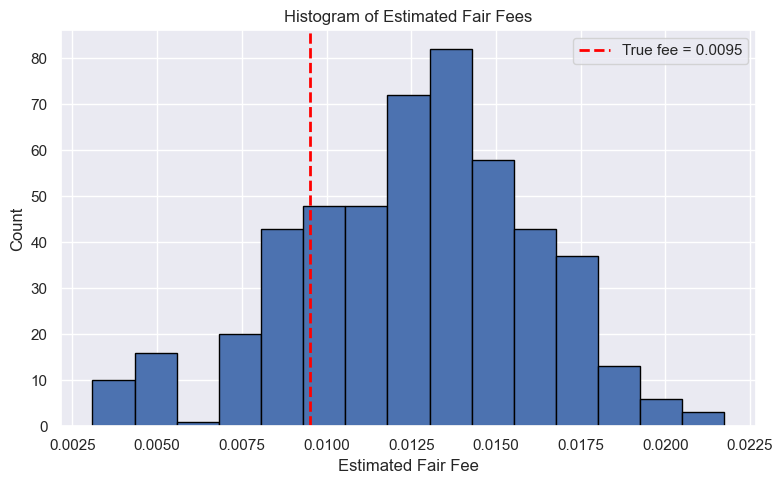

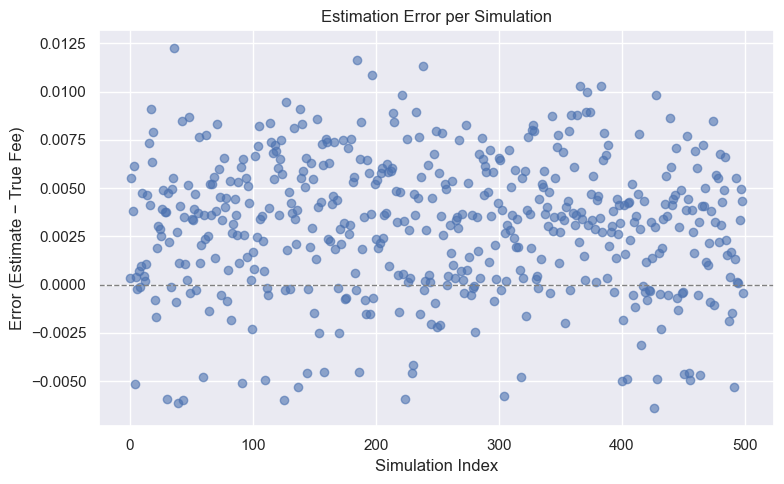

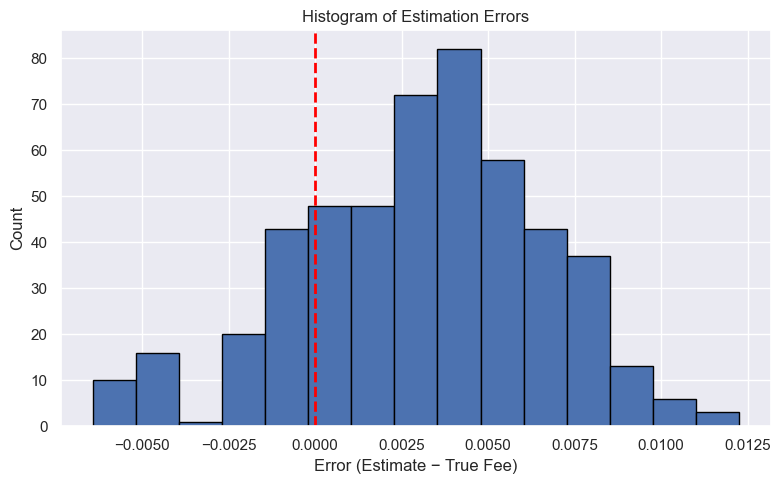

Number of estimates (N): 500
Standard error of fee estimates  : 0.000156668
Standard error of errors         : 0.000156668


In [136]:
fee_one=fair_fee(dic=dic_one)
plot_fairfee_estimates(fair_series=fee_one, true_fee=root_fee)

## simulation without crn using num_sim=1000
### CI of discounted payoffs

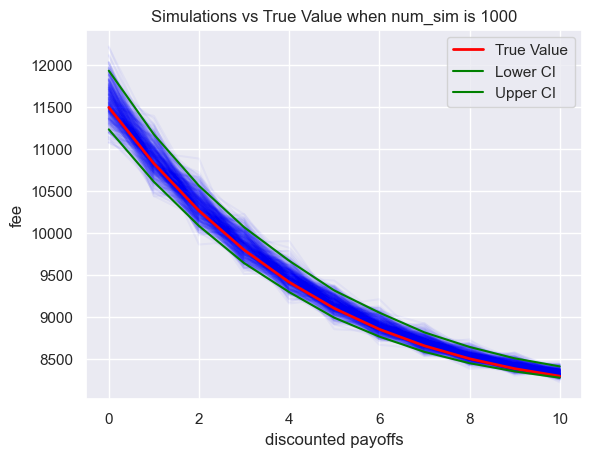

In [125]:
dic_two=iid_simu(num_sim=1000)

In [131]:
dic_two

{0: [11706.347990338669,
  10928.739899583437,
  10231.874380409492,
  9971.99873483735,
  9495.858398220951,
  9158.550055063703,
  8882.446158273448,
  8614.941068947517,
  8528.973063778312,
  8411.466589110356,
  8346.757900047438],
 1: [11384.574296787927,
  10978.54668623585,
  10689.366917804886,
  9832.140944164577,
  9447.222560453138,
  9041.455976309542,
  8829.661570933093,
  8782.333080538972,
  8485.794157270497,
  8458.323088905834,
  8297.256388846972],
 2: [11880.273436184067,
  10957.594031838305,
  10158.199990253146,
  9765.036093282288,
  9360.761335467952,
  9237.120225354778,
  8797.492195243094,
  8780.728858073693,
  8539.789661946294,
  8382.997589508079,
  8252.50677095326],
 3: [11513.664350323792,
  10800.218646154362,
  10392.664887040424,
  9717.978027703062,
  9611.680009706028,
  9229.261186760243,
  8744.631802001517,
  8632.40484475093,
  8577.281713299602,
  8380.48925717914,
  8316.22457649494],
 4: [11814.1039459025,
  10569.70707803316,
  10414.55

### histgram of simulation fees and "true" fee.

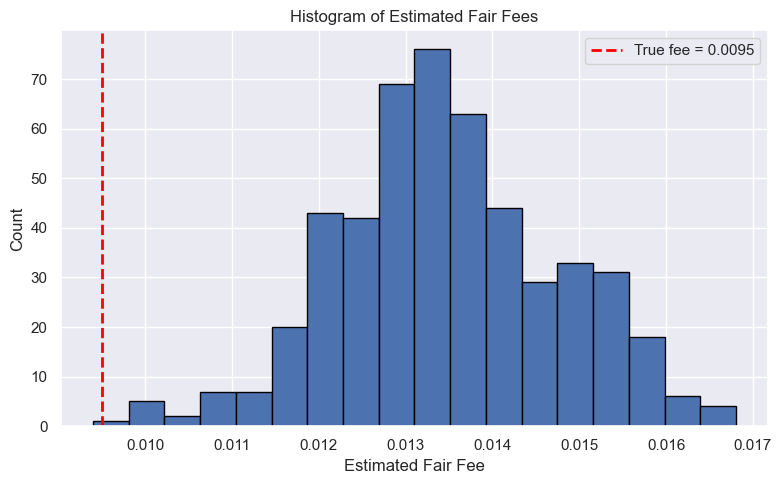

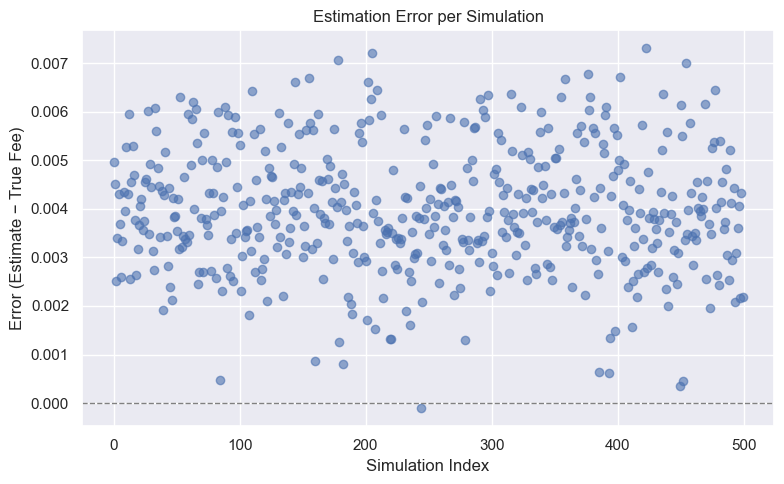

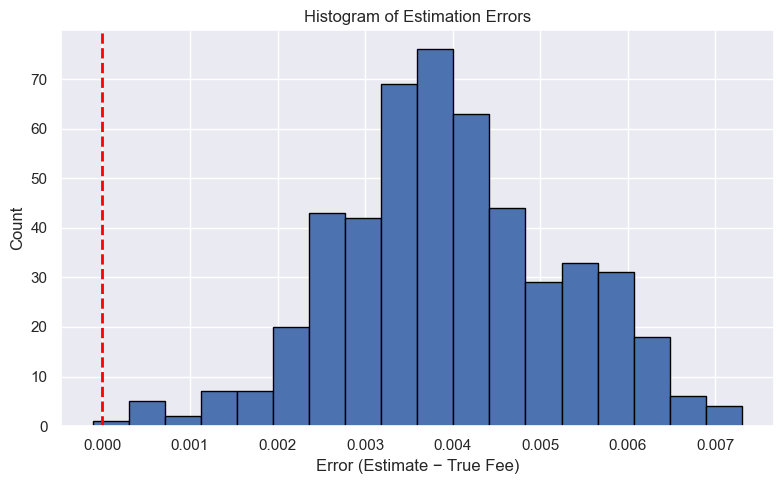

Number of estimates (N): 500
Standard error of fee estimates  : 5.69922e-05
Standard error of errors         : 5.69922e-05


In [126]:
fee_two=fair_fee(dic=dic_two)
plot_fairfee_estimates(fair_series=fee_two, true_fee=root_fee)

## simulation with crn using num_sim=100
### CI of discounted payoffs

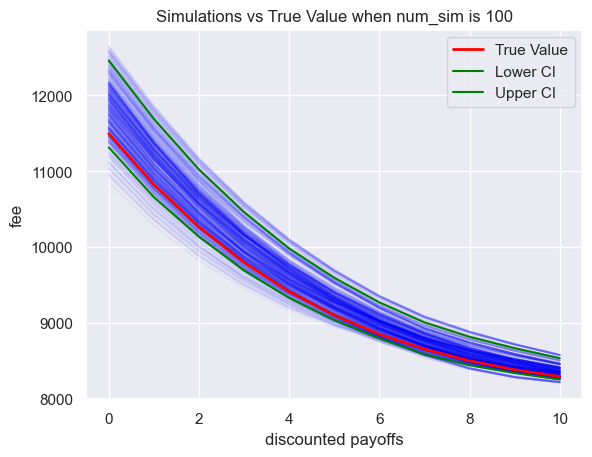

In [189]:
dic_three=iid_simu_crn(num_sim=100)

### histgram of simulation fees and "true" fee.

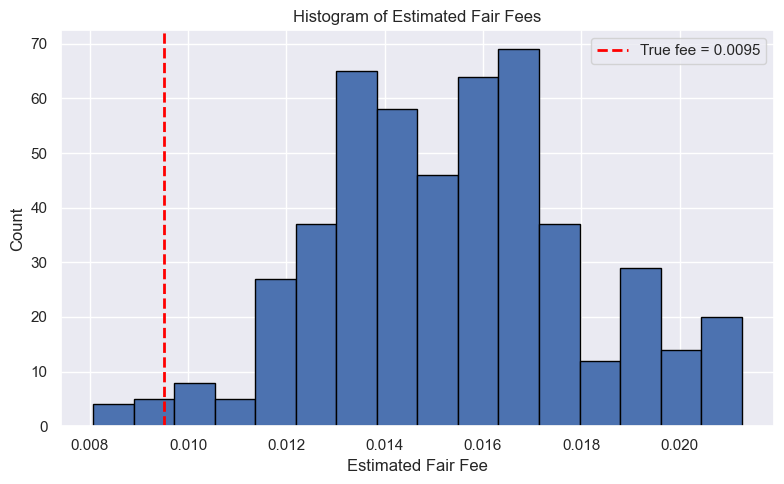

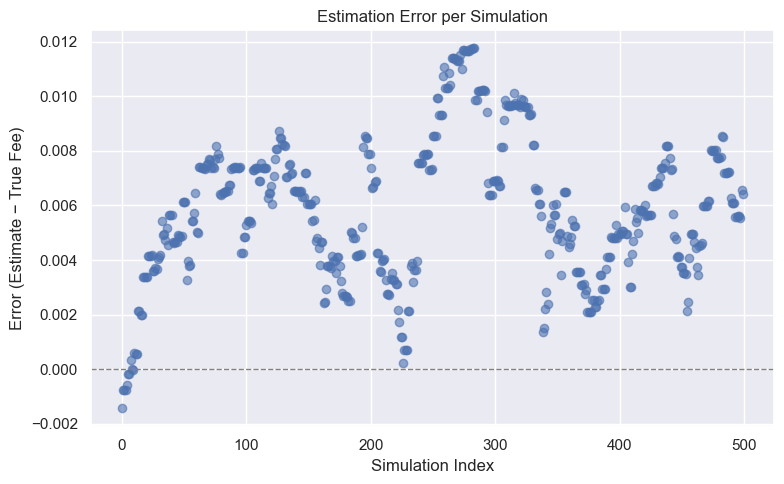

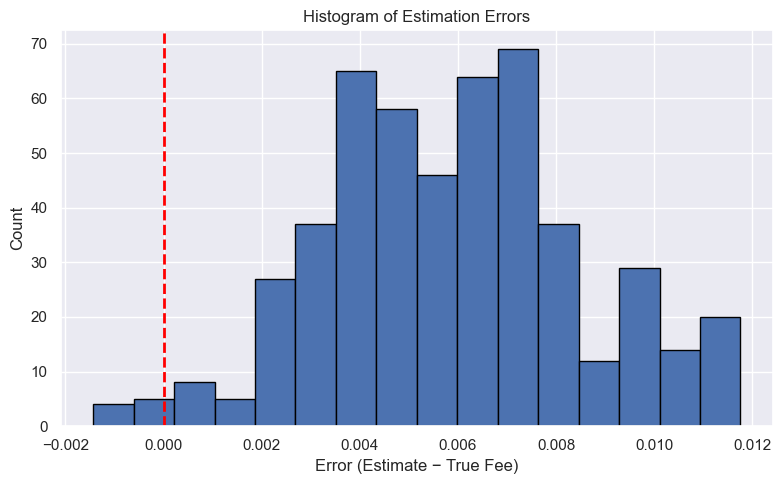

Number of estimates (N): 500
Standard error of fee estimates  : 0.000116555
Standard error of errors         : 0.000116555


In [190]:
fee_three=fair_fee(dic=dic_three)
plot_fairfee_estimates(fair_series=fee_three, true_fee=root_fee)

## simulation with crn using num_sim=1000
### CI of discounted payoffs

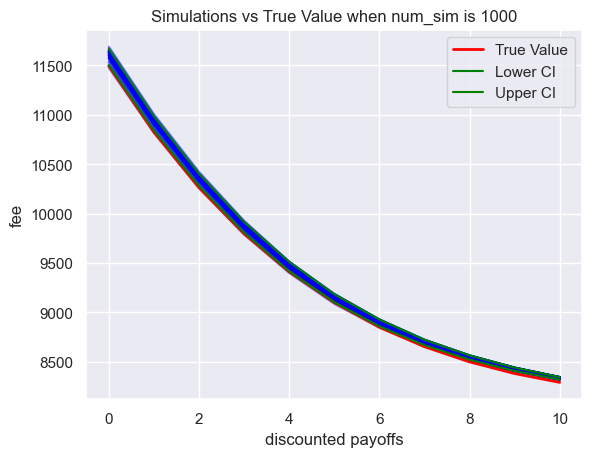

In [191]:
dic_four=iid_simu_crn(num_sim=1000)

### histgram of simulation fees and "true" fee.

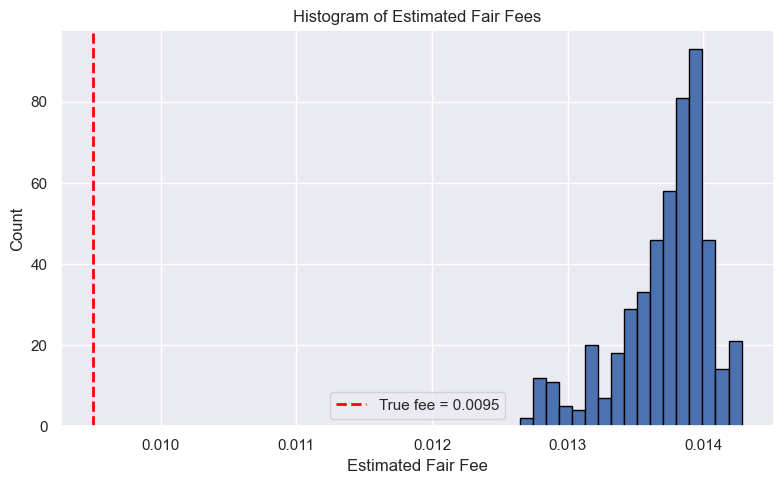

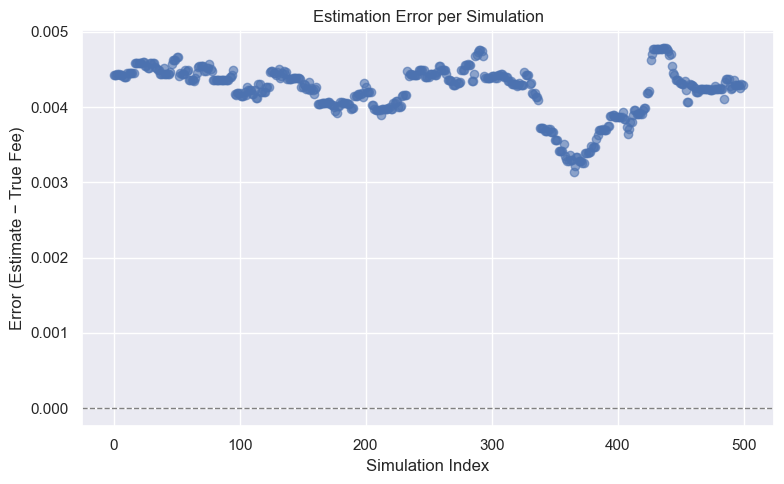

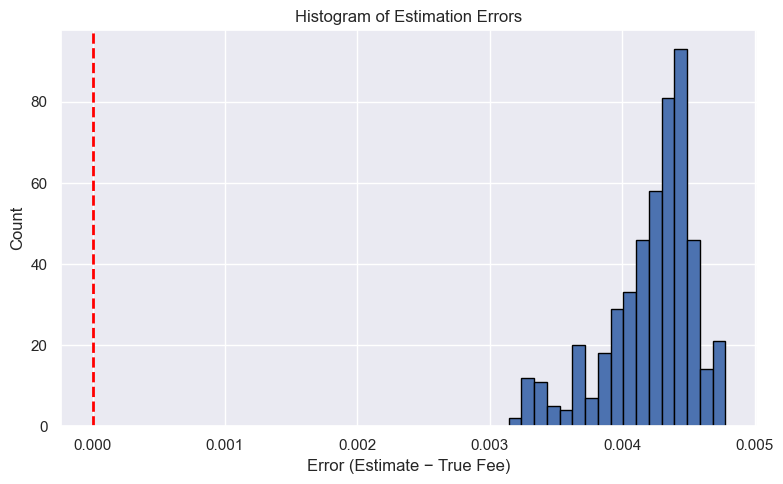

Number of estimates (N): 500
Standard error of fee estimates  : 1.48963e-05
Standard error of errors         : 1.48963e-05


In [192]:
fee_four=fair_fee(dic=dic_four)
plot_fairfee_estimates(fair_series=fee_four, true_fee=root_fee)